In [249]:
import kagglehub
import pandas as pd
import os
import matplotlib.pyplot as plt

### Download data from kaggle

In [250]:
path = kagglehub.dataset_download("jeanmidev/smart-meters-in-london")
TARGET_BLOCKS_DATADIR = os.path.join(path,'hhblock_dataset/hhblock_dataset')
blocks_csv_files = [
        os.path.join(TARGET_BLOCKS_DATADIR, csv_path)
        for csv_path in filter(
            lambda path:
            path.endswith('.csv'),
            os.listdir(TARGET_BLOCKS_DATADIR))
    ]

### Choose the block name and print it

In [251]:
idx = 29
path_specified=f"{TARGET_BLOCKS_DATADIR}/block_{idx}.csv"
block = pd.read_csv(path_specified, encoding='latin', parse_dates=['day'], date_format='%Y-%m-%d')
block.head(5)

,LCLid,day,hh_0,hh_1,hh_2,hh_3,hh_4,hh_5,hh_6,hh_7,...,hh_38,hh_39,hh_40,hh_41,hh_42,hh_43,hh_44,hh_45,hh_46,hh_47
0,MAC000242,2011-12-03,0.027,0.009,0.018,0.027,0.008,0.021,0.026,0.002,...,0.113,0.114,0.103,0.195,0.126,0.066,0.075,0.068,0.059,0.034
1,MAC000242,2011-12-04,0.029,0.020,0.007,0.028,0.024,0.006,0.025,0.025,...,0.118,0.118,0.110,0.154,0.120,0.197,0.101,0.116,0.036,0.017
2,MAC000242,2011-12-05,0.014,0.027,0.021,0.008,0.025,0.026,0.007,0.021,...,0.320,0.127,0.124,0.102,0.135,0.097,0.127,0.180,0.080,0.074
3,MAC000242,2011-12-06,0.012,0.038,0.004,0.036,0.013,0.025,0.023,0.016,...,0.427,0.150,0.124,0.107,0.120,0.095,0.114,0.116,0.104,0.078
4,MAC000242,2011-12-07,0.022,0.015,0.031,0.017,0.012,0.029,0.017,0.012,...,0.111,0.116,0.141,0.104,0.109,0.154,0.146,0.107,0.125,0.019


### This function is used to fill the gaps between days (missing days)

In [252]:
def convert_consumer_to_standard_form(consumer_data, consumer_id, verbose=False):
  start_date = consumer_data['day'].min()
  end_date = consumer_data['day'].max()
  standrad_df = pd.DataFrame()
  standrad_df['day'] = pd.date_range(start=start_date, end=end_date, freq='1D')
  standard_df  = standrad_df.merge(consumer_data, on=['day'], how='left')
  return standard_df

### This function used to convert data to time series data by frequency 30 min (48 read by day)

In [253]:
def convert_standard_form_to_expand_time_series(standard_df, consumer_id,  verbose=False):
  expand_df = pd.melt(standard_df, id_vars=['day','LCLid'],value_name='energy_consumption',var_name='offset')
  expand_df['offset'] = expand_df['offset'].str.replace('hh_','').astype(int)
  expand_df = expand_df.sort_values(by=['day','offset']).reset_index(drop=True)
  expand_df['frequency'] = '30min'
  expand_df['serie_length'] = len(expand_df)
  expand_df['timestamp'] = pd.date_range(start=standard_df['day'].min(), freq='30min', periods=len(expand_df))
  expand_df = expand_df.drop(columns=['day','offset'])
  expand_df = expand_df[['LCLid','timestamp','energy_consumption','frequency','serie_length']]
  return expand_df

In [254]:
block

,LCLid,day,hh_0,hh_1,hh_2,hh_3,hh_4,hh_5,hh_6,hh_7,...,hh_38,hh_39,hh_40,hh_41,hh_42,hh_43,hh_44,hh_45,hh_46,hh_47
0,MAC000242,2011-12-03,0.027,0.009,0.018,0.027,0.008,0.021,0.026,0.002,...,0.113,0.114,0.103,0.195,0.126,0.066,0.075,0.068,0.059,0.034
1,MAC000242,2011-12-04,0.029,0.020,0.007,0.028,0.024,0.006,0.025,0.025,...,0.118,0.118,0.110,0.154,0.120,0.197,0.101,0.116,0.036,0.017
2,MAC000242,2011-12-05,0.014,0.027,0.021,0.008,0.025,0.026,0.007,0.021,...,0.320,0.127,0.124,0.102,0.135,0.097,0.127,0.180,0.080,0.074
3,MAC000242,2011-12-06,0.012,0.038,0.004,0.036,0.013,0.025,0.023,0.016,...,0.427,0.150,0.124,0.107,0.120,0.095,0.114,0.116,0.104,0.078
4,MAC000242,2011-12-07,0.022,0.015,0.031,0.017,0.012,0.029,0.017,0.012,...,0.111,0.116,0.141,0.104,0.109,0.154,0.146,0.107,0.125,0.019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33472,MAC005032,2014-02-23,0.239,0.127,0.167,0.164,0.142,0.132,0.067,0.116,...,0.358,0.152,0.204,0.250,0.251,0.255,0.345,0.246,0.196,0.253
33473,MAC005032,2014-02-24,0.240,0.239,0.263,0.133,0.097,0.087,0.085,0.151,...,0.200,0.165,0.625,0.241,0.117,0.150,0.204,0.234,0.266,0.240
33474,MAC005032,2014-02-25,0.219,0.248,0.226,0.226,0.155,0.075,0.081,0.096,...,0.494,0.186,0.194,0.232,0.232,0.219,0.222,0.212,0.172,0.374
33475,MAC005032,2014-02-26,0.206,0.166,0.184,0.118,0.135,0.146,0.100,0.150,...,0.179,0.133,0.179,0.118,0.108,0.177,0.131,0.217,0.211,0.356


In [255]:
result = block.groupby('LCLid').apply(lambda group: convert_consumer_to_standard_form(group, group.name)).reset_index(drop=True)
result

<ipython-input-255-35de716bdf25>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = block.groupby('LCLid').apply(lambda group: convert_consumer_to_standard_form(group, group.name)).reset_index(drop=True)


,day,LCLid,hh_0,hh_1,hh_2,hh_3,hh_4,hh_5,hh_6,hh_7,...,hh_38,hh_39,hh_40,hh_41,hh_42,hh_43,hh_44,hh_45,hh_46,hh_47
0,2011-12-03,MAC000242,0.027,0.009,0.018,0.027,0.008,0.021,0.026,0.002,...,0.113,0.114,0.103,0.195,0.126,0.066,0.075,0.068,0.059,0.034
1,2011-12-04,MAC000242,0.029,0.020,0.007,0.028,0.024,0.006,0.025,0.025,...,0.118,0.118,0.110,0.154,0.120,0.197,0.101,0.116,0.036,0.017
2,2011-12-05,MAC000242,0.014,0.027,0.021,0.008,0.025,0.026,0.007,0.021,...,0.320,0.127,0.124,0.102,0.135,0.097,0.127,0.180,0.080,0.074
3,2011-12-06,MAC000242,0.012,0.038,0.004,0.036,0.013,0.025,0.023,0.016,...,0.427,0.150,0.124,0.107,0.120,0.095,0.114,0.116,0.104,0.078
4,2011-12-07,MAC000242,0.022,0.015,0.031,0.017,0.012,0.029,0.017,0.012,...,0.111,0.116,0.141,0.104,0.109,0.154,0.146,0.107,0.125,0.019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33684,2014-02-23,MAC005032,0.239,0.127,0.167,0.164,0.142,0.132,0.067,0.116,...,0.358,0.152,0.204,0.250,0.251,0.255,0.345,0.246,0.196,0.253
33685,2014-02-24,MAC005032,0.240,0.239,0.263,0.133,0.097,0.087,0.085,0.151,...,0.200,0.165,0.625,0.241,0.117,0.150,0.204,0.234,0.266,0.240
33686,2014-02-25,MAC005032,0.219,0.248,0.226,0.226,0.155,0.075,0.081,0.096,...,0.494,0.186,0.194,0.232,0.232,0.219,0.222,0.212,0.172,0.374
33687,2014-02-26,MAC005032,0.206,0.166,0.184,0.118,0.135,0.146,0.100,0.150,...,0.179,0.133,0.179,0.118,0.108,0.177,0.131,0.217,0.211,0.356


In [256]:
expand_form = result.groupby('LCLid').apply(lambda group: convert_standard_form_to_expand_time_series(group, group.name)).reset_index(drop=True).drop_duplicates()
expand_form

<ipython-input-256-c6c5c428ad93>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  expand_form = result.groupby('LCLid').apply(lambda group: convert_standard_form_to_expand_time_series(group, group.name)).reset_index(drop=True).drop_duplicates()


,LCLid,timestamp,energy_consumption,frequency,serie_length
0,MAC000242,2011-12-03 00:00:00,0.027,30min,38832
1,MAC000242,2011-12-03 00:30:00,0.009,30min,38832
2,MAC000242,2011-12-03 01:00:00,0.018,30min,38832
3,MAC000242,2011-12-03 01:30:00,0.027,30min,38832
4,MAC000242,2011-12-03 02:00:00,0.008,30min,38832
...,...,...,...,...,...
1606891,MAC005032,2014-02-23 21:30:00,0.153,30min,36192
1606892,MAC005032,2014-02-23 22:00:00,0.248,30min,36192
1606893,MAC005032,2014-02-23 22:30:00,0.179,30min,36192
1606894,MAC005032,2014-02-23 23:00:00,0.154,30min,36192


In [257]:
expand_form["energy_consumption"].isna().sum()

np.int64(50)

 - use specific LCLid (consumer) and visualize its reads with time (TimeSeries Analysis)
 - interplolate (impute) the NAN values in the Energy Consumption col

In [258]:
ts_df = expand_form[expand_form.LCLid=="MAC005032"].set_index("timestamp")
ts_df['energy_consumption'] = ts_df['energy_consumption'].interpolate(method='polynomial',order=3)

In [259]:
ts_df

,LCLid,energy_consumption,frequency,serie_length
timestamp,,,,
2012-02-01 00:00:00,MAC005032,0.164,30min,36192
2012-02-01 00:30:00,MAC005032,0.156,30min,36192
2012-02-01 01:00:00,MAC005032,0.110,30min,36192
2012-02-01 01:30:00,MAC005032,0.182,30min,36192
2012-02-01 02:00:00,MAC005032,0.140,30min,36192
...,...,...,...,...
2014-02-23 21:30:00,MAC005032,0.153,30min,36192
2014-02-23 22:00:00,MAC005032,0.248,30min,36192
2014-02-23 22:30:00,MAC005032,0.179,30min,36192


In [260]:
ts_df["energy_consumption"].isna().sum()

np.int64(0)

### Add some properities to use in visualizations and analysis


In [261]:
ts_df["weekday_name"] = ts_df.index.day_name()
ts_df["weekday"] = ts_df.index.weekday
ts_df["week"] = ts_df.index.isocalendar().week
ts_df["day"] = ts_df.index.day
ts_df["hour"] = ts_df.index.hour
ts_df["date"] = ts_df.index.date
ts_df["month"] = ts_df.index.month
ts_df["month_name"] = ts_df.index.month_name()
ts_df["year"] = ts_df.index.year

In [262]:
ts_df['month_name'] = pd.Categorical(ts_df['month_name'], categories=["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"], ordered=True)
ts_df['weekday_name'] = pd.Categorical(ts_df['weekday_name'], categories=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], ordered=True)

In [263]:
ts_df

,LCLid,energy_consumption,frequency,serie_length,weekday_name,weekday,week,day,hour,date,month,month_name,year
timestamp,,,,,,,,,,,,,
2012-02-01 00:00:00,MAC005032,0.164,30min,36192,Wednesday,2,5,1,0,2012-02-01,2,February,2012
2012-02-01 00:30:00,MAC005032,0.156,30min,36192,Wednesday,2,5,1,0,2012-02-01,2,February,2012
2012-02-01 01:00:00,MAC005032,0.110,30min,36192,Wednesday,2,5,1,1,2012-02-01,2,February,2012
2012-02-01 01:30:00,MAC005032,0.182,30min,36192,Wednesday,2,5,1,1,2012-02-01,2,February,2012
2012-02-01 02:00:00,MAC005032,0.140,30min,36192,Wednesday,2,5,1,2,2012-02-01,2,February,2012
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-02-23 21:30:00,MAC005032,0.153,30min,36192,Sunday,6,8,23,21,2014-02-23,2,February,2014
2014-02-23 22:00:00,MAC005032,0.248,30min,36192,Sunday,6,8,23,22,2014-02-23,2,February,2014
2014-02-23 22:30:00,MAC005032,0.179,30min,36192,Sunday,6,8,23,22,2014-02-23,2,February,2014


In [264]:
weekly_df = ts_df.groupby(["year","month","week"])[['energy_consumption']].mean()
weekly_df

energy_consumption
year month week                    
2012 2     5               0.169721
           6               0.179289
           7               0.163307
           8               0.160568
           9               0.167201
...                             ...
2014 1     5               0.164267
     2     5               0.171635
           6               0.174949
           7               0.178545
           8               0.171021

[129 rows x 1 columns]

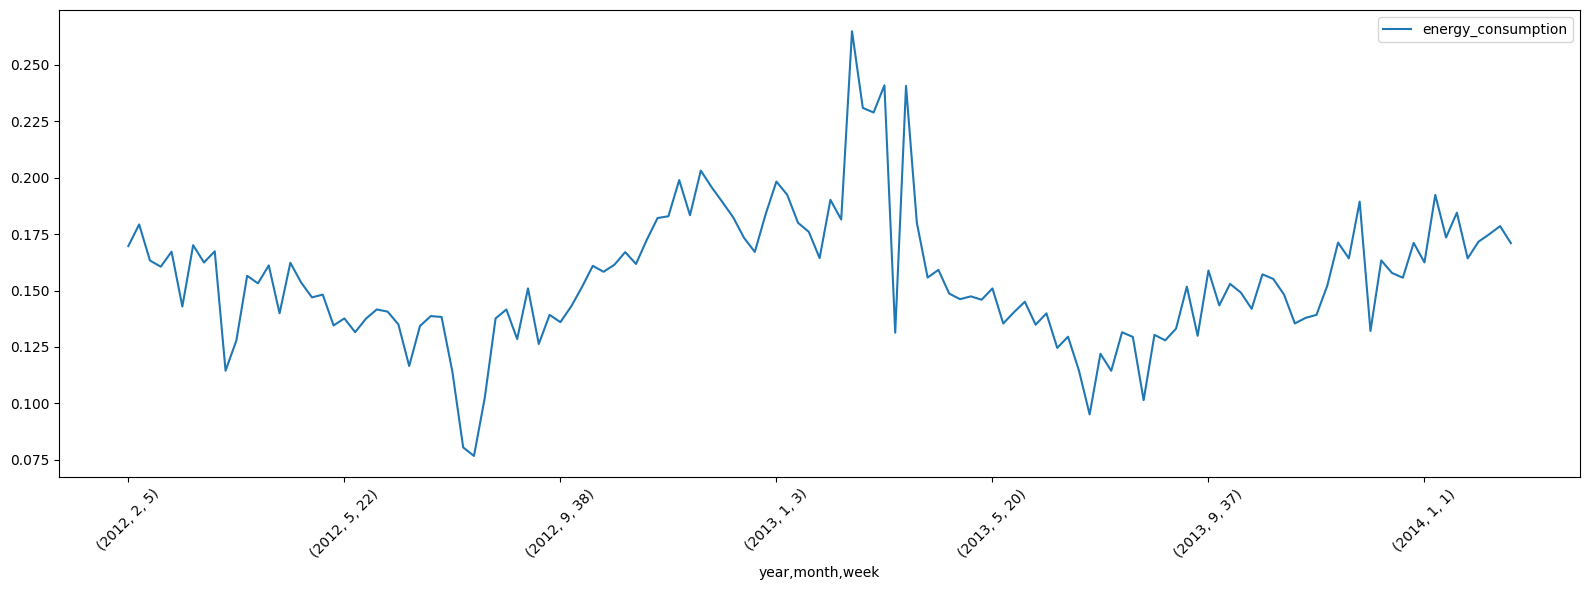

In [265]:
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
weekly_df.plot(ax=ax)
plt.xticks(rotation=45)
fig.tight_layout()
plt.show()

### The plot seems that the time series is non stationary so we will try to discover the reason of this

In [266]:
from statsmodels.tsa.stattools import adfuller

adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(weekly_df)
print(f"The adf is :{adf},\n The pvalue is :{pvalue},\n The critical_values is :{critical_values}")
print("The pvalue is here > .05 so the data is non stationary")

The adf is :-1.8917756220279283,
 The pvalue is :0.33593995419762246,
 The critical_values is :{'1%': np.float64(-3.484219653271961), '5%': np.float64(-2.885145235641637), '10%': np.float64(-2.579359138917794)}
The pvalue is here > .05 so the data is non stationary


In [267]:
from statsmodels.tsa.stattools import kpss

kpss_stat, p_value, lags, critical_values = kpss(weekly_df)

print(f"The kpss is :{kpss_stat},\n The pvalue is :{p_value},\n The critical_values is :{critical_values}")
print("The pvalue is here > .05 so the data is stationary")

The kpss is :0.15568224569281364,
 The pvalue is :0.1,
 The critical_values is :{'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
The pvalue is here > .05 so the data is stationary


<ipython-input-267-9a3010a7647b>:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, p_value, lags, critical_values = kpss(weekly_df)


### There is conflict between two tests  
- KPSS indicates stationarity and ADF indicates non-stationarity - The series is trend stationary. Trend needs to be removed to make series strict stationary. The detrended series is checked for stationarity.

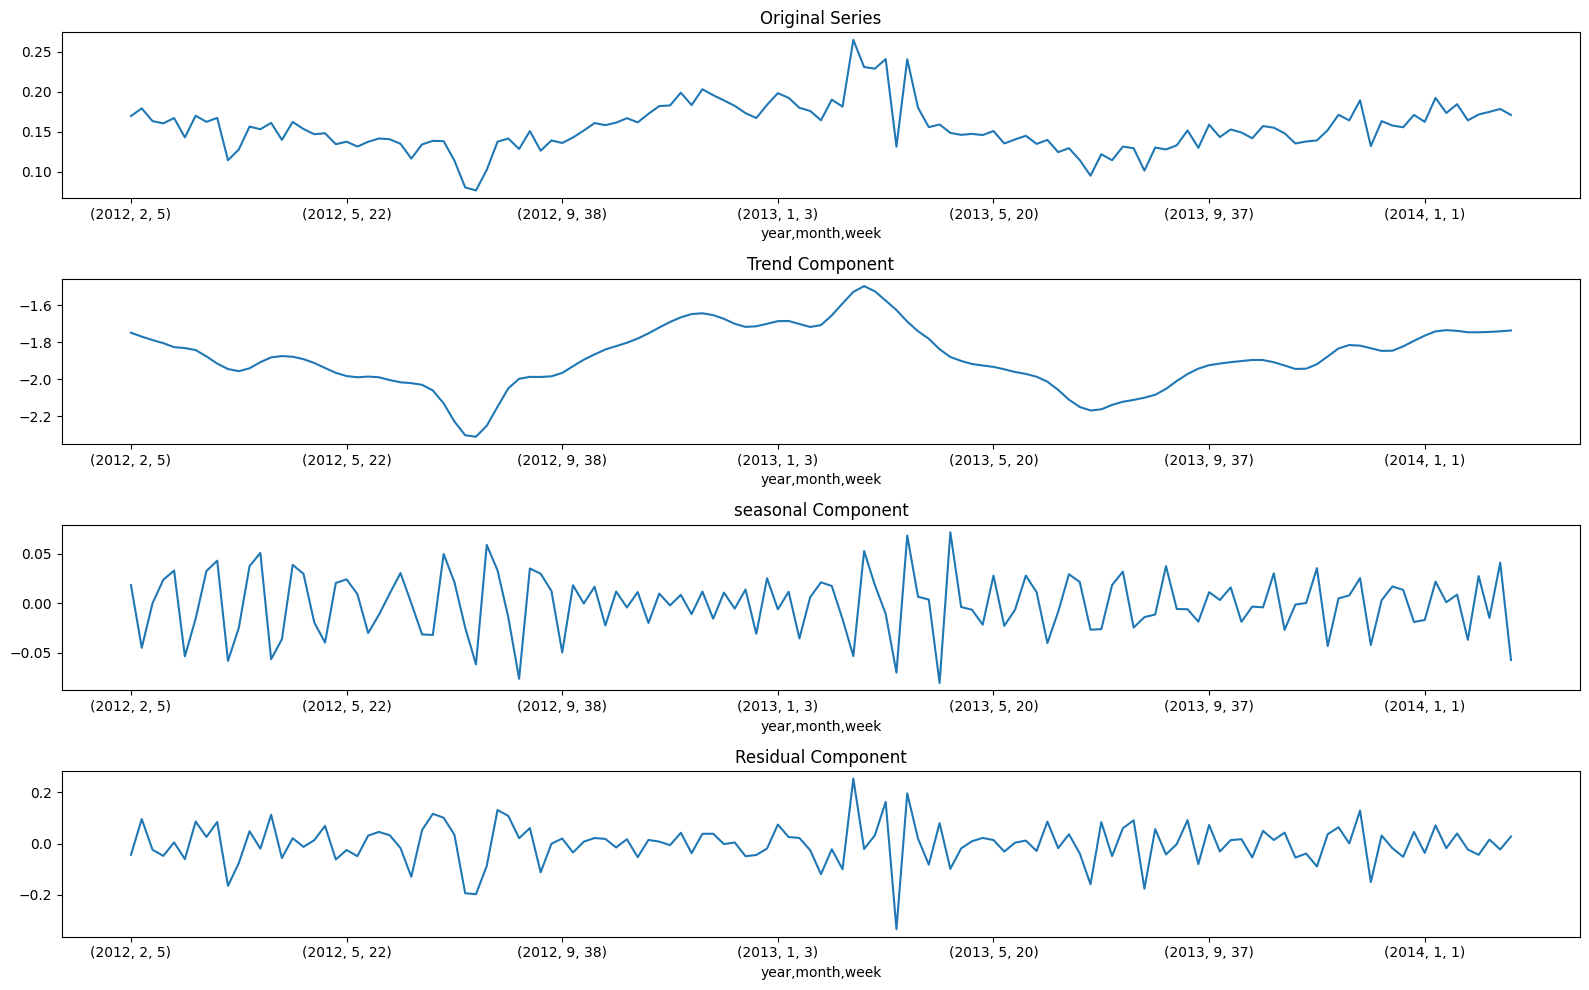

In [268]:
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt
import numpy as np

stl = STL(np.log(weekly_df['energy_consumption']), period=4)

res = stl.fit()

fig, axs = plt.subplots(4, 1, figsize=(16, 10))

weekly_df['energy_consumption'].plot(ax=axs[0], title='Original Series')
res.trend.plot(ax=axs[1], title='Trend Component')
res.seasonal.plot(ax=axs[2], title='seasonal Component')
res.resid.plot(ax=axs[3], title='Residual Component')

plt.tight_layout()
plt.show()


### This technique cannot decompose seasonality so i will try different mothod

<ipython-input-290-5cac6d2ef0cf>:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


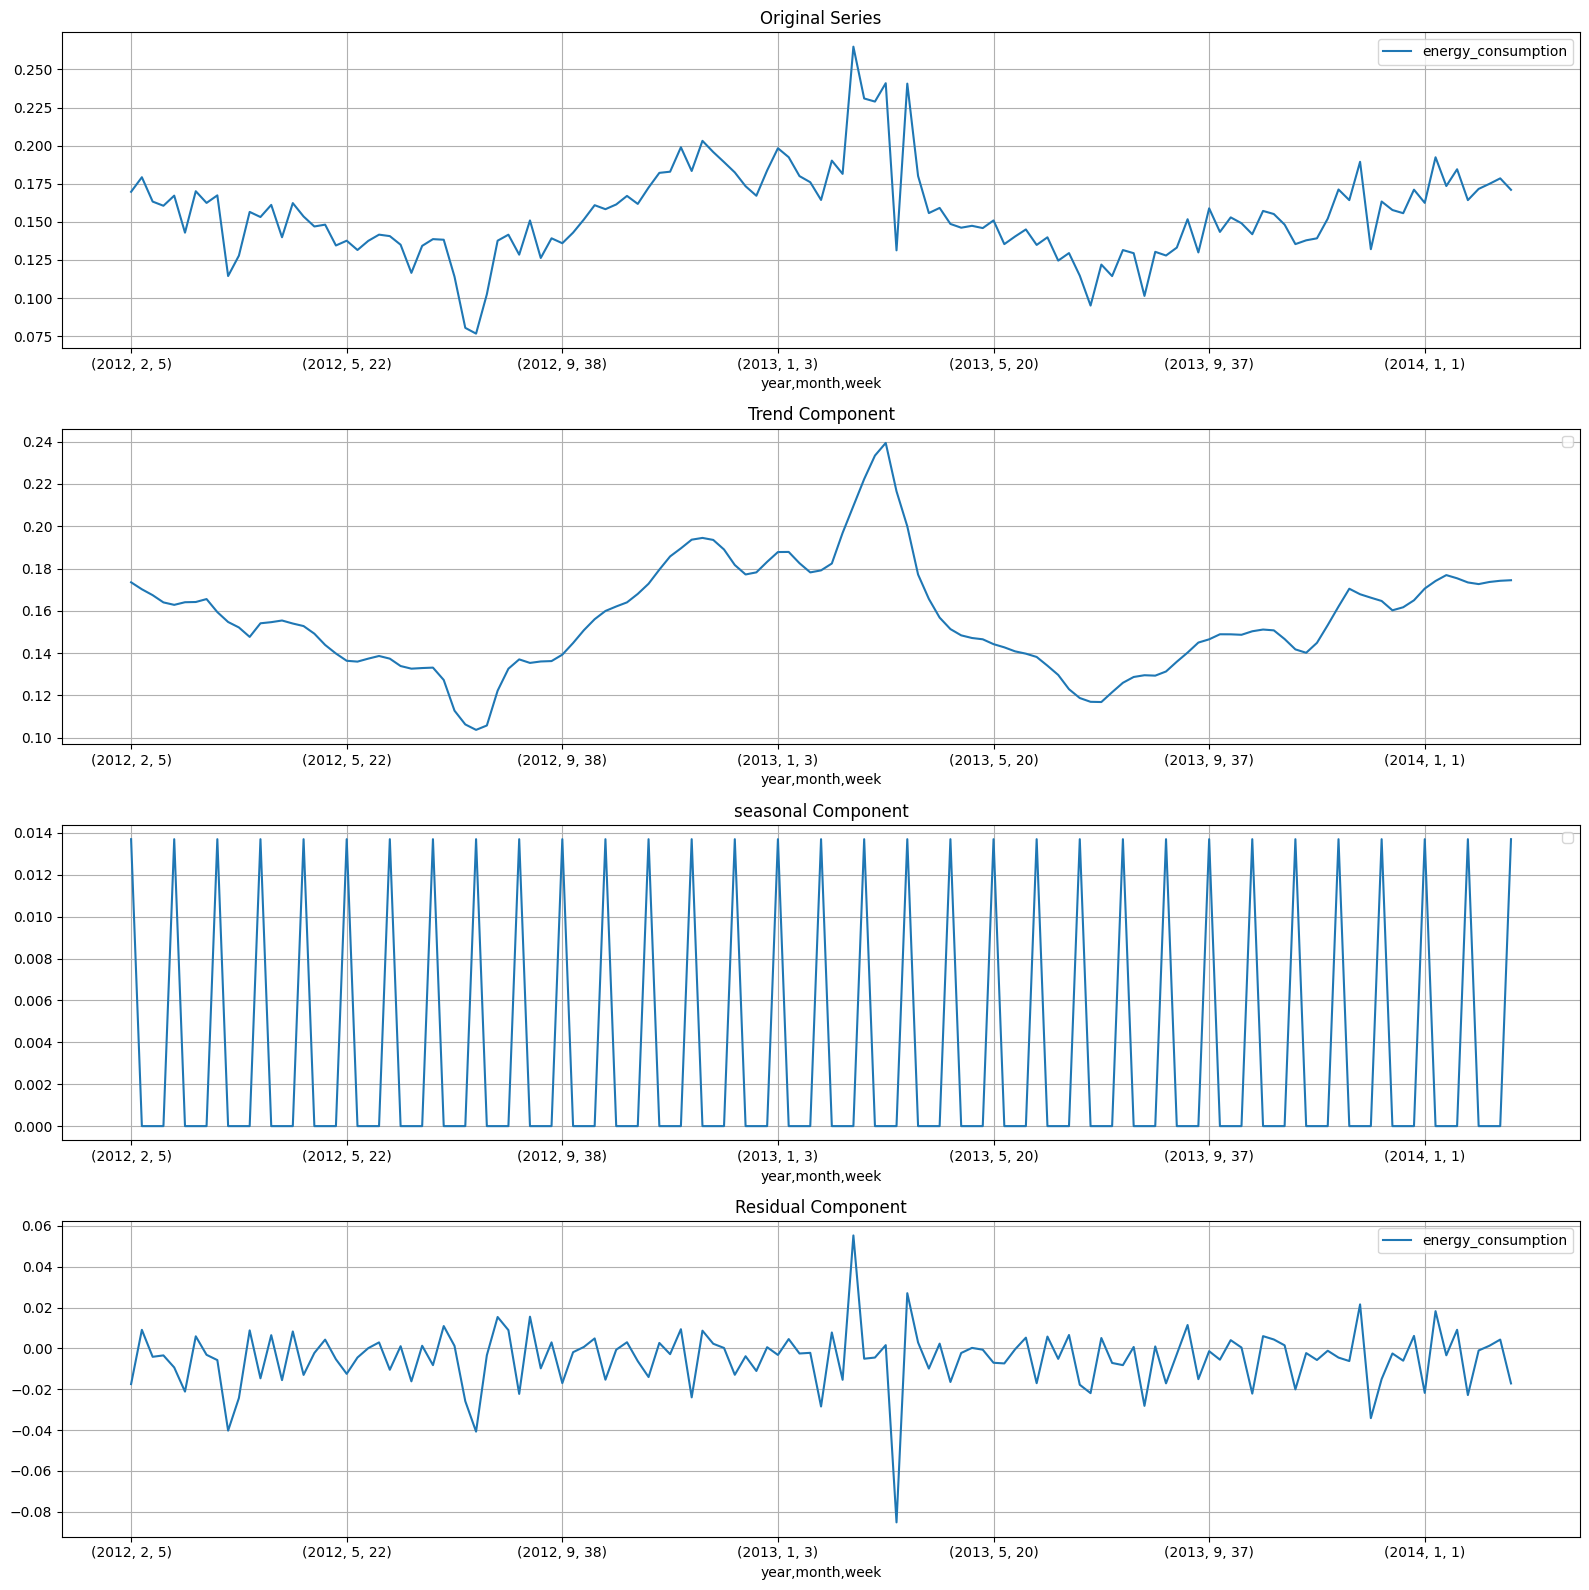

In [290]:
from statsmodels.nonparametric.smoothers_lowess import lowess
import numpy as np

trend = lowess(weekly_df[ 'energy_consumption'], range(len(weekly_df)), frac=0.05)[:, 1]
detrended_series = weekly_df[ 'energy_consumption'] - trend

time = np.arange(len(weekly_df[ 'energy_consumption']))
seasonal = np.zeros_like(weekly_df[ 'energy_consumption'])
for i in range(1, 3+ 1):
    seasonal += (np.sin(2 * np.pi * i * time / 4) +
                np.cos(2 * np.pi * i * time / 4))

seasonal = (seasonal - seasonal.min()) / (seasonal.max() - seasonal.min())
seasonal = seasonal * detrended_series.std()

residual = detrended_series - seasonal
trend = pd.Series(index=weekly_df.index, data=trend)
seasonal = pd.Series(index=weekly_df.index, data=seasonal)
residual = pd.Series(index=weekly_df.index, data=residual)

fig, axs = plt.subplots(4, 1, figsize=(16, 16))
weekly_df['energy_consumption'].plot(ax=axs[0], title='Original Series')
trend.plot(ax=axs[1], title='Trend Component')
seasonal.plot(ax=axs[2], title='seasonal Component')
residual.plot(ax=axs[3], title='Residual Component')

for ax in axs:
    ax.legend()
    ax.grid()
fig.tight_layout()



In [291]:
weekly_df_without_trend_seasonality = weekly_df["energy_consumption"] - trend - seasonal

In [292]:
from statsmodels.tsa.stattools import adfuller

adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(weekly_df_without_trend_seasonality )
print(f"The adf is :{adf},\n The pvalue is :{pvalue},\n The critical_values is :{critical_values}")
print("The pvalue is here < .05 so the data is stationary")

The adf is :-9.031720657437502,
 The pvalue is :5.422382796016006e-15,
 The critical_values is :{'1%': np.float64(-3.4837793736959997), '5%': np.float64(-2.88495387648), '10%': np.float64(-2.579256976)}
The pvalue is here < .05 so the data is stationary


In [293]:
from statsmodels.tsa.stattools import kpss

kpss_stat, p_value, lags, critical_values = kpss(weekly_df_without_trend_seasonality )

print(f"The kpss is :{kpss_stat},\n The pvalue is :{p_value},\n The critical_values is :{critical_values}")
print("The pvalue is here > .05 so the data is stationary")

The kpss is :0.10973691577053225,
 The pvalue is :0.1,
 The critical_values is :{'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
The pvalue is here > .05 so the data is stationary


<ipython-input-293-623e74fd382d>:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, p_value, lags, critical_values = kpss(weekly_df_without_trend_seasonality )


### The Two tests said the same thing after differencing so the data is stationary now

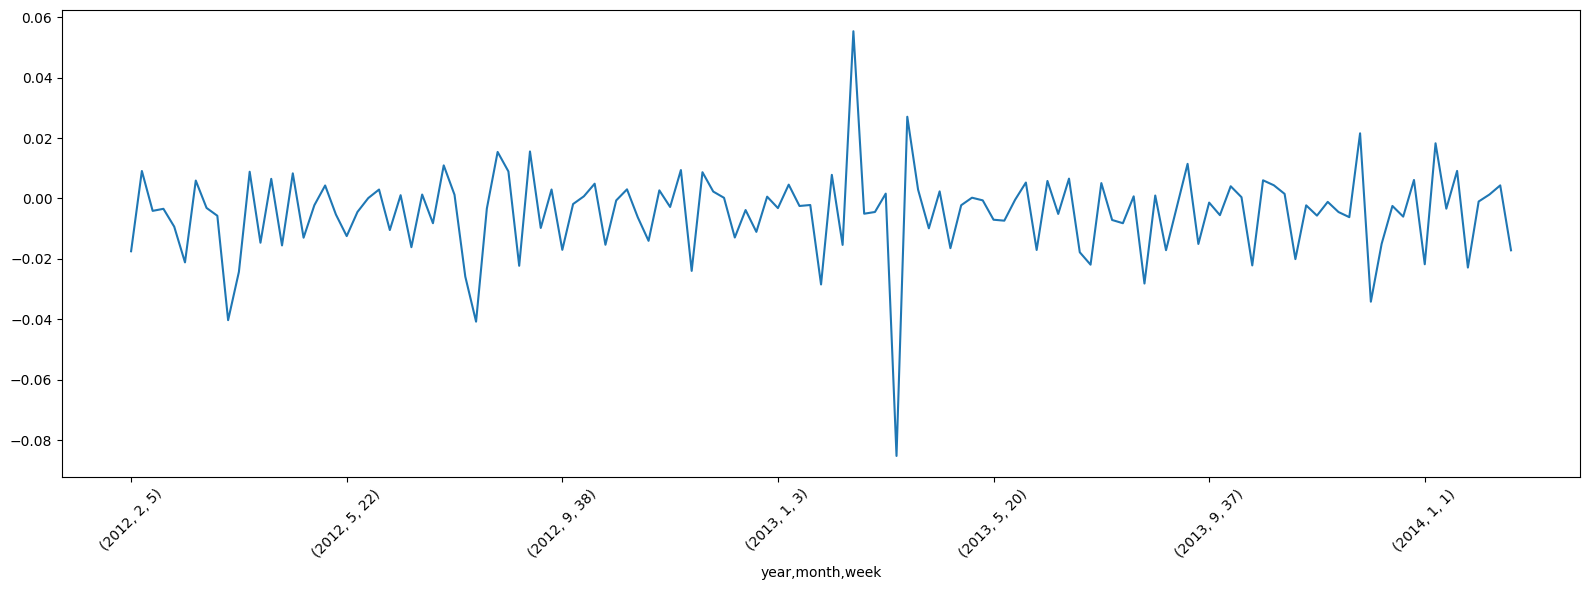

In [294]:
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
weekly_df_without_trend_seasonality.plot(ax=ax)
plt.xticks(rotation=45)
fig.tight_layout()
plt.show()

### So the data now is stationary so i will now plot the ACF and PACF to discover what i will need in ARMA model

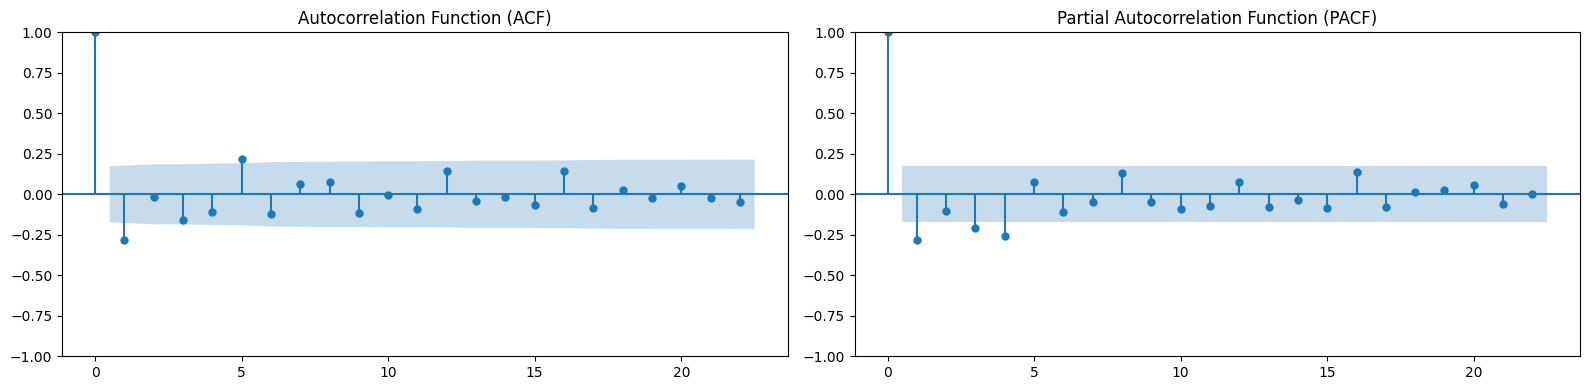

In [295]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, figsize=(16, 4))

plot_acf(weekly_df_without_trend_seasonality, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')

plot_pacf(weekly_df_without_trend_seasonality, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

### I will consider p =1 , q=1 , d=1


In [296]:
weekly_df_without_trend_seasonality

year  month  week
2012  2      5      -0.017461
             6       0.009104
             7      -0.004097
             8      -0.003414
             9      -0.009322
                       ...   
2014  1      5      -0.022852
      2      5      -0.001000
             6       0.001313
             7       0.004342
             8      -0.017144
Length: 129, dtype: float64

In [297]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

In [298]:
# Step 1: Convert year-week to datetime (ISO standard)
without_trend_seasonality_fixed_index = weekly_df_without_trend_seasonality.reset_index()
without_trend_seasonality_fixed_index['week_str'] = without_trend_seasonality_fixed_index['year'].astype(str) + '-W' + without_trend_seasonality_fixed_index['week'].astype(str).str.zfill(2)
without_trend_seasonality_fixed_index['date'] = pd.to_datetime(without_trend_seasonality_fixed_index['week_str'] + '-1', format='%G-W%V-%u')  # '-1' = Monday

# Step 2: Set as time index
without_trend_seasonality_fixed_index = without_trend_seasonality_fixed_index.set_index('date').sort_index()

# Step 3: Drop duplicates if any
without_trend_seasonality_fixed_index = without_trend_seasonality_fixed_index[~without_trend_seasonality_fixed_index.index.duplicated(keep='first')]

# Optional: Keep only the column you need
without_trend_seasonality_fixed_index = without_trend_seasonality_fixed_index[[0]]

In [299]:
without_trend_seasonality_fixed_index

,0
date,
2012-01-02,-0.023958
2012-01-30,-0.017461
2012-02-06,0.009104
2012-02-13,-0.004097
2012-02-20,-0.003414
...,...
2014-01-20,0.009130
2014-01-27,-0.022852
2014-02-03,0.001313



=== ARIMA(1,1,1) ===


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


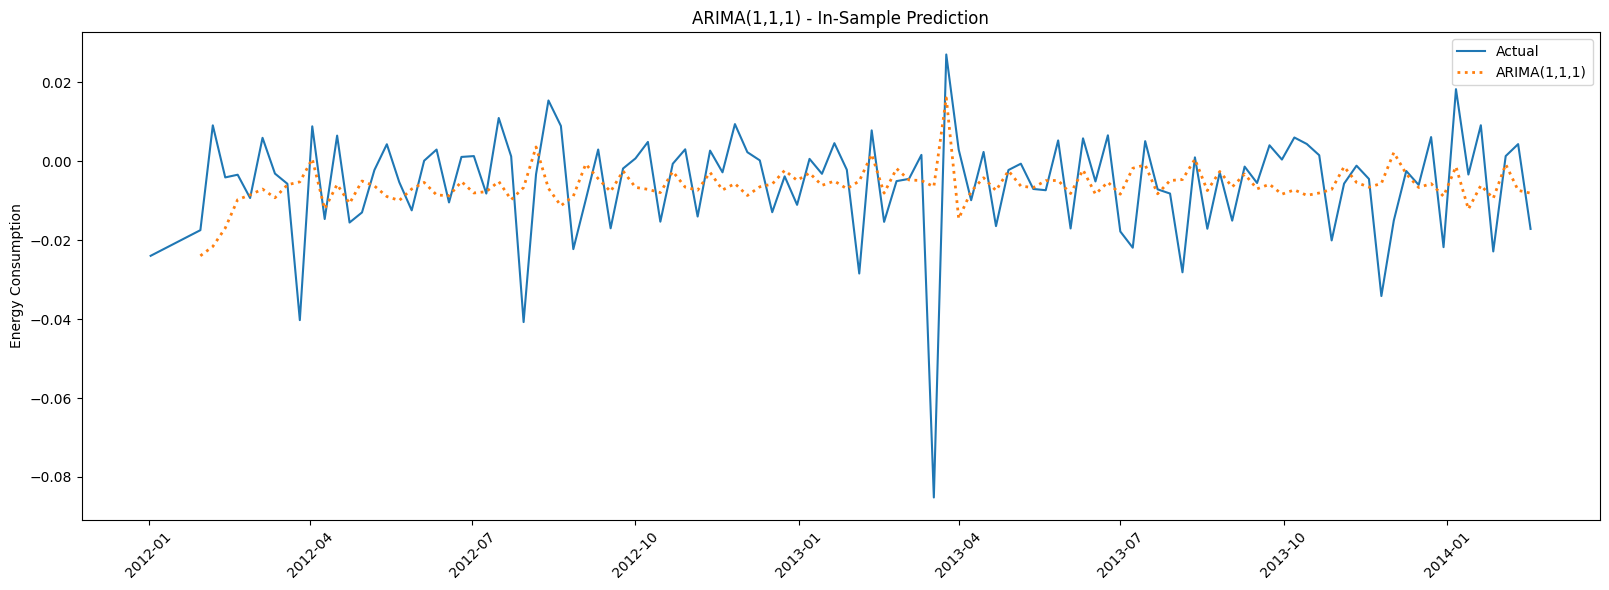

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  109
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 311.119
Date:                Sun, 20 Apr 2025   AIC                           -616.237
Time:                        21:45:13   BIC                           -608.191
Sample:                             0   HQIC                          -612.975
                                - 109                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2743      0.117     -2.340      0.019      -0.504      -0.045
ma.L1         -0.9985      0.926     -1.078      0.281      -2.814       0.817
sigma2         0.0002      0.000      1.107      0.2

In [300]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Step 4: ARIMA modeling for different differencing levels

print(f"\n=== ARIMA(1,1,1) ===")

model = ARIMA(without_trend_seasonality_fixed_index[0], order=(1, 1, 1)).fit()

plt.figure(figsize=(16, 6))
plt.plot(without_trend_seasonality_fixed_index.index, without_trend_seasonality_fixed_index[0], label="Actual")

pred = model.predict(start=1, end=len(without_trend_seasonality_fixed_index)-1, typ='levels')
plt.plot(without_trend_seasonality_fixed_index.index[1:], pred, label=f"ARIMA(1,1,1)", linestyle='dotted', linewidth=2)

plt.title(f"ARIMA(1,1,1) - In-Sample Prediction")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.ylabel("Energy Consumption")
plt.show()

print(model.summary())

### I didn't use SARIMA because i don't have any Seasonality in data

In [280]:
!pip install statsforecast

In [301]:
from statsforecast.models import AutoARIMA
from statsforecast.core import StatsForecast

In [302]:
st = StatsForecast( models=[AutoARIMA(season_length=0)],
                   freq='w',
                   n_jobs=1)

In [303]:
weekly_df_series_auto = without_trend_seasonality_fixed_index.reset_index()

In [304]:
weekly_df_series_auto = pd.DataFrame({
    'ds': weekly_df_series_auto['date'],
    'y':weekly_df_series_auto[0],
    'unique_id' : 'MAC005032_block29'
})

In [305]:
weekly_df_series_auto

,ds,y,unique_id
0,2012-01-02,-0.023958,MAC005032_block29
1,2012-01-30,-0.017461,MAC005032_block29
2,2012-02-06,0.009104,MAC005032_block29
3,2012-02-13,-0.004097,MAC005032_block29
4,2012-02-20,-0.003414,MAC005032_block29
...,...,...,...
104,2014-01-20,0.009130,MAC005032_block29
105,2014-01-27,-0.022852,MAC005032_block29
106,2014-02-03,0.001313,MAC005032_block29
107,2014-02-10,0.004342,MAC005032_block29


In [306]:
forecast_df = st.forecast(h= len(ts_df), df=weekly_df_series_auto, time_col='ds', target_col='y', fitted=True)

/usr/local/lib/python3.11/dist-packages/utilsforecast/processing.py:384: FutureWarning: 'w' is deprecated and will be removed in a future version, please use 'W' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/usr/local/lib/python3.11/dist-packages/utilsforecast/processing.py:440: FutureWarning: 'w' is deprecated and will be removed in a future version, please use 'W' instead.
  freq = pd.tseries.frequencies.to_offset(freq)


In [307]:
st.fit(weekly_df_series_auto)

StatsForecast(models=[AutoARIMA])

<Axes: xlabel='ds'>

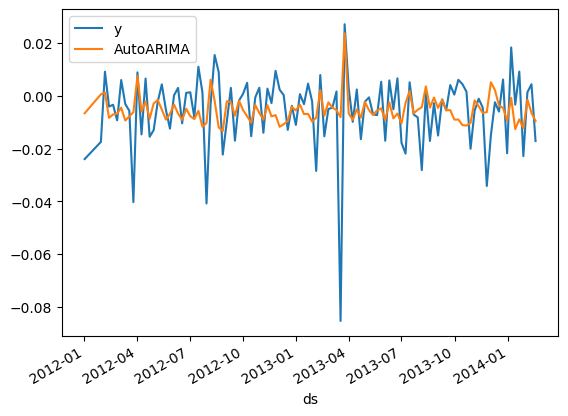

In [308]:
fitted_values = st.forecast_fitted_values()
fitted_values.plot(x='ds', y=['y', 'AutoARIMA'])

In [309]:
fitted_model = st.fitted_[0, 0].model_

arma = fitted_model['arma']
p, d, q = arma[0], arma[4], arma[1]
P, D, Q, m = arma[2], arma[5], arma[3], arma[6]

print(f"Non-seasonal order (p, d, q): {(p, d, q)}")
print(f"Seasonal order (P, D, Q, m): {(P, D, Q, m)}")

Non-seasonal order (p, d, q): (0, 1, 1)
Seasonal order (P, D, Q, m): (0, 0, 0, 0)


### Please i want comments about whyyyyy after decomposition the autoarima model can't fit the data